In [87]:
# try everything here
import sys
import networkx as nx # type: ignore
import graphviz
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dowhy import CausalModel
import statsmodels.formula.api as smf

sys.path.append('../')
from src.data.make_dataset import load_data, merge_all_datasets

In [3]:
# Loading Data
data_dict = load_data()

olist_customers_df = data_dict['olist_customers_df']
olist_geolocation_df = data_dict['olist_geolocation_df']
olist_order_items_df = data_dict['olist_order_items_df']
olist_order_payments_df = data_dict['olist_order_payments_df']
olist_order_reviews_df = data_dict['olist_order_reviews_df']
olist_orders_df = data_dict['olist_orders_df']
olist_products_df = data_dict['olist_products_df']
olist_sellers_df = data_dict['olist_sellers_df']
product_category_name_translation_df = data_dict['product_category_name_translation_df']

olist_closed_deals_df = data_dict['olist_closed_deals_df']
olist_marketing_qualified_leads_df = data_dict['olist_marketing_qualified_leads_df']

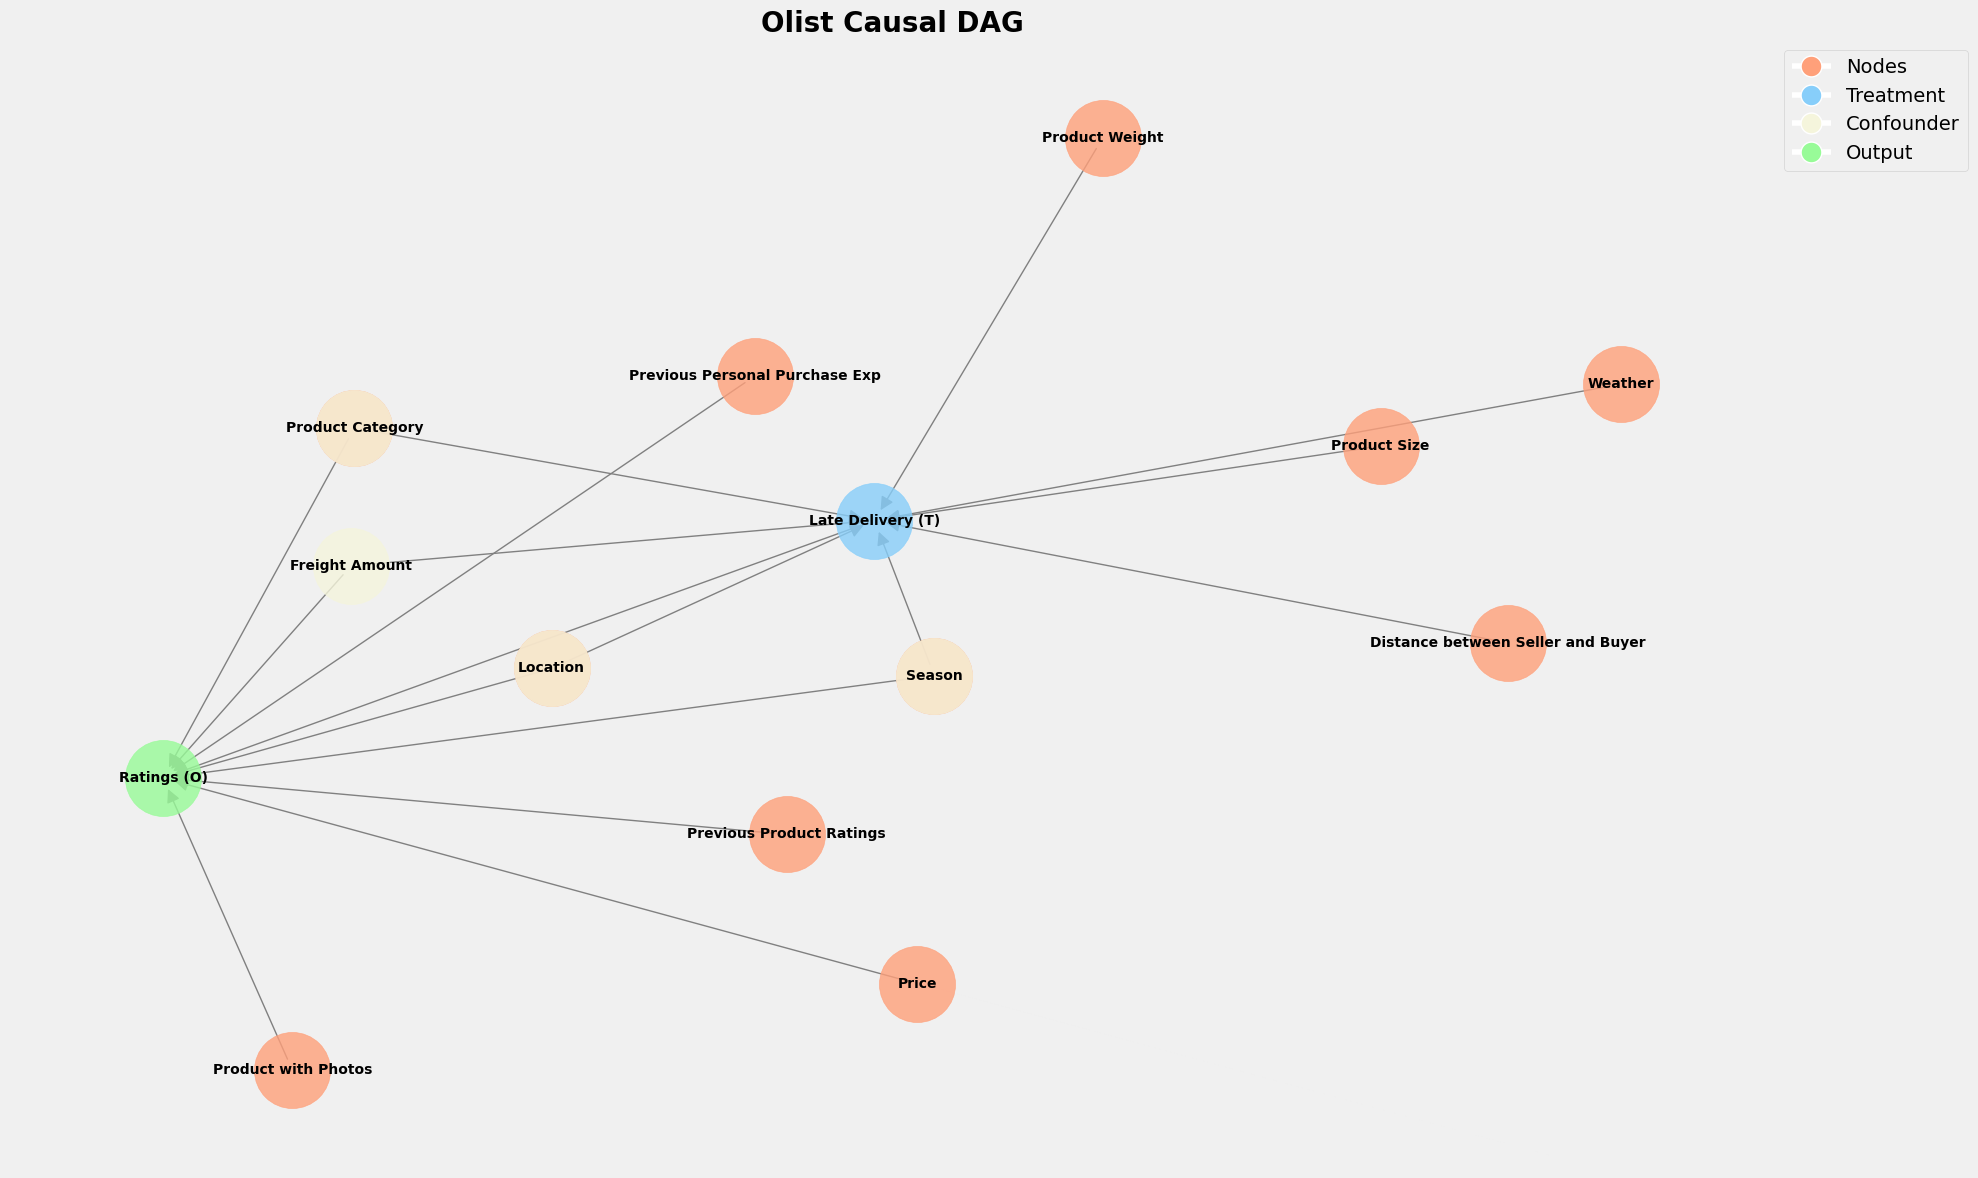

In [22]:
# Set the style
plt.style.use('fivethirtyeight')
sns.set_palette("pastel")

# Create a new directed graph
G = nx.DiGraph()

# Add nodes
nodes = [
    "Product Weight",
    "Weather",
    "Distance between Seller and Buyer",
    "Product Size",
    "Late Delivery (T)",
    "Previous Product Ratings",
    "Product with Photos",
    "Ratings (O)",
    "Price",
    "Previous Personal Purchase Exp",
    "Location",
    "Product Category",
    "Season",
    "Freight Amount"
]
G.add_nodes_from(nodes)

# Add edges (relationships)
edges = [
    ("Weather", "Late Delivery (T)"),
    ("Product Weight", "Late Delivery (T)"),
    ("Distance between Seller and Buyer", "Late Delivery (T)"),
    ("Product Size", "Late Delivery (T)"),
    ("Late Delivery (T)", "Ratings (O)"),
    ("Previous Product Ratings", "Ratings (O)"),
    ("Product with Photos", "Ratings (O)"),
    ("Price", "Ratings (O)"),
    ("Previous Personal Purchase Exp", "Ratings (O)"),
    ("Location", "Late Delivery (T)"),
    ("Location", "Ratings (O)"),
    ("Product Category", "Late Delivery (T)"),
    ("Product Category", "Ratings (O)"),
    ("Season", "Late Delivery (T)"),
    ("Season", "Ratings (O)"),
    ("Freight Amount", "Late Delivery (T)"),
    ("Freight Amount", "Ratings (O)")
]
G.add_edges_from(edges)

# Set up the plot
plt.figure(figsize=(20, 12))
pos = nx.spring_layout(G, k=0.5, iterations=50)

# Color mapping
color_map = {
    "nodes": "#FFA07A",     # Light Salmon
    "treatment": "#87CEFA",  # Light Sky Blue
    "confounder": "#F5F5DC",
    "output": "#98FB98"     # Pale Green
}

# Categorize nodes
node_categories = {
    "nodes": ["Product Weight", "Weather", "Distance between Seller and Buyer", "Product Size", "Previous Product Ratings", 
              "Product with Photos", "Price", "Previous Personal Purchase Exp", 
              "Location", "Product Category", "Season"],
    'confounder': ['Location', 'Product Category', 'Season', 'Freight Amount'],
    "treatment": ["Late Delivery (T)"],
    "output": ["Ratings (O)"]
}

# Draw nodes
for category, node_list in node_categories.items():
    nx.draw_networkx_nodes(G, pos, nodelist=node_list, node_color=color_map[category], 
                           node_size=3000, alpha=0.8)

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=20)

# Add labels
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

# Create a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=cat.capitalize(),
                              markerfacecolor=color, markersize=15)
                   for cat, color in color_map.items()]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.title("Olist Causal DAG", fontsize=20, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


In [121]:
df = merge_all_datasets(olist_customers_df, 
                       olist_geolocation_df,
                       olist_order_items_df,
                       olist_order_payments_df,
                       olist_order_reviews_df, 
                       olist_orders_df,
                       olist_products_df, 
                       olist_sellers_df
                       )

In [122]:
df.isnull().sum()

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                   177
order_delivered_carrier_date       2086
order_delivered_customer_date      3421
order_estimated_delivery_date         0
order_item_id                       833
product_id                          833
seller_id                           833
shipping_limit_date                 833
price                               833
freight_value                       833
payment_sequential                    3
payment_type                          3
payment_installments                  3
payment_value                         3
review_id                           997
review_score                        997
review_comment_title             105154
review_comment_message            68898
review_creation_date                997
review_answer_timestamp             997
product_category_name              2542


rainfall variable

In [123]:
rainfall_categories = {
    'North': {1: 'High', 2: 'High', 3: 'High', 4: 'Moderate', 5: 'Moderate', 6: 'Low', 7: 'Low', 8: 'Low', 9: 'Moderate', 10: 'Moderate', 11: 'High', 12: 'High'},
    'Northeast': {1: 'Low', 2: 'Moderate', 3: 'Moderate', 4: 'High', 5: 'High', 6: 'Moderate', 7: 'Low', 8: 'Low', 9: 'Low', 10: 'Moderate', 11: 'Moderate', 12: 'High'},
    'Central-West': {1: 'High', 2: 'High', 3: 'High', 4: 'Moderate', 5: 'Low', 6: 'Low', 7: 'Low', 8: 'Low', 9: 'Low', 10: 'Moderate', 11: 'High', 12: 'High'},
    'Southeast': {1: 'High', 2: 'High', 3: 'Moderate', 4: 'Moderate', 5: 'Low', 6: 'Low', 7: 'Low', 8: 'Low', 9: 'Moderate', 10: 'Moderate', 11: 'High', 12: 'High'},
    'South': {1: 'Moderate', 2: 'Moderate', 3: 'Moderate', 4: 'Moderate', 5: 'Moderate', 6: 'Low', 7: 'Low', 8: 'Low', 9: 'Moderate', 10: 'Moderate', 11: 'Moderate', 12: 'High'}
}

state_to_region = {
    'AC': 'North', 'AP': 'North', 'AM': 'North', 'PA': 'North', 'RO': 'North', 'RR': 'North', 'TO': 'North',
    'AL': 'Northeast', 'BA': 'Northeast', 'CE': 'Northeast', 'MA': 'Northeast', 'PB': 'Northeast', 'PE': 'Northeast', 'PI': 'Northeast', 'RN': 'Northeast', 'SE': 'Northeast',
    'GO': 'Central-West', 'MT': 'Central-West', 'MS': 'Central-West', 'DF': 'Central-West',
    'ES': 'Southeast', 'MG': 'Southeast', 'RJ': 'Southeast', 'SP': 'Southeast',
    'PR': 'South', 'RS': 'South', 'SC': 'South'
}



def get_rainfall_category(region, month):

    rainfall_categories = {
    'North': {1: 'High', 2: 'High', 3: 'High', 4: 'Moderate', 5: 'Moderate', 6: 'Low', 7: 'Low', 8: 'Low', 9: 'Moderate', 10: 'Moderate', 11: 'High', 12: 'High'},
    'Northeast': {1: 'Low', 2: 'Moderate', 3: 'Moderate', 4: 'High', 5: 'High', 6: 'Moderate', 7: 'Low', 8: 'Low', 9: 'Low', 10: 'Moderate', 11: 'Moderate', 12: 'High'},
    'Central-West': {1: 'High', 2: 'High', 3: 'High', 4: 'Moderate', 5: 'Low', 6: 'Low', 7: 'Low', 8: 'Low', 9: 'Low', 10: 'Moderate', 11: 'High', 12: 'High'},
    'Southeast': {1: 'High', 2: 'High', 3: 'Moderate', 4: 'Moderate', 5: 'Low', 6: 'Low', 7: 'Low', 8: 'Low', 9: 'Moderate', 10: 'Moderate', 11: 'High', 12: 'High'},
    'South': {1: 'Moderate', 2: 'Moderate', 3: 'Moderate', 4: 'Moderate', 5: 'Moderate', 6: 'Low', 7: 'Low', 8: 'Low', 9: 'Moderate', 10: 'Moderate', 11: 'Moderate', 12: 'High'}
    }

    return rainfall_categories.get(region).get(month, 'Unknown')


In [124]:
# Convert 'order_approved_at' column to datetime if it's not already
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])

# Extract the month from 'order_approved_at'
df['month'] = df['order_approved_at'].dt.month

# Map state to region
df['region'] = df['customer_state'].map(state_to_region)       # --------------> or seller_state?

# Map region to rainfall
df['rainfall_level'] = df.apply(lambda row: get_rainfall_category(row['region'], row['month']), axis=1)

weight variable

In [125]:
df['Product_weight_kg'] = df['product_weight_g']/1000

distance variable

In [126]:
# Define the Haversine function
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points
    on the Earth's surface given their latitude and longitude in decimal degrees.
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    r = 6371  # Radius of Earth in kilometers
    distance = r * c

    return distance

# Example DataFrame
# df = pd.read_csv('path_to_your_data.csv')  # Replace with your actual data loading code

# Calculate distance for each row in the DataFrame
df['distance_km'] = df.apply(
    lambda row: haversine(
        row['geolocation_lat_x'], row['geolocation_lng_x'],
        row['geolocation_lat_y'], row['geolocation_lng_y']
    ),
    axis=1
)

product category variable

In [127]:
df['Product_category'] = df['product_category_name']

size variable

In [128]:
df['Product_size'] = df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']

### Previous rating

Rolling average of a customers previous rating (if they dont have previous orders it will be the same rating)

In [129]:
df = df.sort_values(by=['customer_id', 'review_answer_timestamp'])

# Create a new column for the rolling mean excluding the last review
def rolling_mean_excluding_last(group):
    return group['review_score'].shift(1).rolling(window=len(group) - 1).mean()

df['customer_avg_score'] = df.groupby('customer_id').apply(rolling_mean_excluding_last).reset_index(drop=True)

# If the customer has no previous scores, just use the current score
df['customer_avg_score'] = df['customer_avg_score'].fillna(df['review_score'])

/var/folders/7s/18428v6x0c9g1ltv9g71gm1h0000gn/T/ipykernel_44357/3204792575.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['customer_avg_score'] = df.groupby('customer_id').apply(rolling_mean_excluding_last).reset_index(drop=True)


Rolling average of a sellers previous rating (if they dont have previous orders it will be the same rating)

In [130]:
# Previous Personal Purchase Experience

# Sort the dataframe by customer and order purchase timestamp
df = df.sort_values(by=['seller_id', 'order_purchase_timestamp'])

# Define a function to compute the rolling mean of previous review scores for each customer
def rolling_mean_previous_customer(group):
    # Shift to exclude the current review and calculate rolling mean of all previous reviews
    return group['review_score'].shift(1).expanding().mean()

# Apply the function to each group of customers
df['seller_hist_rating'] = df.groupby('seller_id').apply(rolling_mean_previous_customer).reset_index(drop=True)

# Handle cases where there are no previous reviews (NaN values) by setting them to 0 or any default value
df['seller_hist_rating'] = df['seller_hist_rating'].fillna(0)

/var/folders/7s/18428v6x0c9g1ltv9g71gm1h0000gn/T/ipykernel_44357/1062401438.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['seller_hist_rating'] = df.groupby('seller_id').apply(rolling_mean_previous_customer).reset_index(drop=True)


No_photos variable

In [133]:
df['No_photos'] = df['product_photos_qty']

Price variable

In [134]:
df['Product_price'] = df['price']

Delivery late variable

In [135]:
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

df['late_delivery_in_days'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days

df['is_delivery_late'] = np.where(df['late_delivery_in_days'] > 0, 1, 0)

Rating Variable

In [136]:
df['Rating']= df['review_score']

Seasonality

In [137]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['season'] = df['order_purchase_timestamp'].dt.month

In [138]:
df['price']

0         895.0
2         895.0
1         895.0
98         99.9
26         99.9
          ...  
118427      NaN
118894      NaN
118529      NaN
118704      NaN
118804      NaN
Name: price, Length: 119143, dtype: float64

In [139]:
df_final = df[['order_id', 
               'payment_value', 
               'Rating',
               'rainfall_level',
               'region', 
               'Product_weight_kg', 
               'distance_km',
               'Product_category', 
               'Product_size', 
               'customer_avg_score',
               'No_photos',
               'Product_price', 
               'seller_hist_rating', 
               'season', 
               'is_delivery_late',
               'Product_price']]

In [140]:
df_final

,order_id,payment_value,Rating,rainfall_level,region,Product_weight_kg,distance_km,Product_category,Product_size,customer_avg_score,No_photos,Product_price,seller_hist_rating,season,is_delivery_late,Product_price
0,d455a8cb295653b55abda06d434ab492,916.02,5.0,Moderate,South,11.800,687.434185,eletroportateis,61920.0,5.0,2.0,895.0,0.000000,9,0,895.0
2,9dc8d1a6f16f1b89874c29c9d8d30447,916.02,5.0,Moderate,Southeast,11.800,714.295670,eletroportateis,61920.0,5.0,2.0,895.0,5.000000,10,0,895.0
1,7f39ba4c9052be115350065d07583cac,916.02,1.0,Moderate,Southeast,11.800,417.139650,eletroportateis,61920.0,1.0,2.0,895.0,5.000000,10,0,895.0
98,3c655487f0c8e34cde2c7b67de8f08cc,121.05,2.0,High,Central-West,8.875,1735.329124,ferramentas_jardim,24080.0,2.0,4.0,99.9,3.819149,2,0,99.9
26,eb188a175542057d90b3ca5628b7b5a0,573.85,4.0,High,Southeast,8.875,523.615247,ferramentas_jardim,24080.0,4.0,4.0,99.9,3.565217,2,0,99.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118427,392ed9afd714e3c74767d0c4d3e3f477,137.03,1.0,Unknown,Southeast,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.000000,9,0,NaN
118894,616fa7d4871b87832197b2a137a115d2,80.38,2.0,Unknown,Southeast,NaN,NaN,NaN,NaN,2.0,NaN,NaN,0.000000,10,0,NaN
118529,a2ac6dad85cf8af5b0afb510a240fe8c,197.55,1.0,Unknown,Southeast,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.000000,10,0,NaN
118704,b059ee4de278302d550a3035c4cdb740,222.03,5.0,Unknown,Northeast,NaN,NaN,NaN,NaN,5.0,NaN,NaN,0.000000,10,0,NaN


In [83]:
df_final.isnull().sum()

order_id                 0
payment_value            3
Rating                 997
rainfall_level           0
region                   0
Product_weight_kg      853
distance_km           1414
Product_category      2542
Product_size           853
customer_avg_score     896
No_photos             2542
Product_price          833
seller_hist_rating       0
season                   0
is_delivery_late         0
dtype: int64

In [89]:

model = smf.ols(formula='Rating ~ is_delivery_late', data=df_final)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                 1.391e+04
Date:                Sun, 22 Sep 2024   Prob (F-statistic):               0.00
Time:                        21:45:30   Log-Likelihood:            -2.0086e+05
No. Observations:              118146   AIC:                         4.017e+05
Df Residuals:                  118144   BIC:                         4.017e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.1328      0.004  

In [94]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [102]:
df_final['Rating'] = df_final['Rating'].fillna(df_final['Rating'].mean())

In [105]:

# Fit Ordinal Logistic Regression model
model = OrderedModel(df_final['Rating'], df_final['is_delivery_late'], distr='logit')
results = model.fit(method='bfgs')

# Print the summary of the results
print(results.summary())


Optimization terminated successfully.
         Current function value: 1.228526
         Iterations: 28
         Function evaluations: 31
         Gradient evaluations: 31
                             OrderedModel Results                             
Dep. Variable:                 Rating   Log-Likelihood:            -1.4637e+05
Model:                   OrderedModel   AIC:                         2.928e+05
Method:            Maximum Likelihood   BIC:                         2.928e+05
Date:                Sun, 22 Sep 2024                                         
Time:                        21:54:27                                         
No. Observations:              119143                                         
Df Residuals:                  119137                                         
Df Model:                           1                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

In [106]:
# Fit Ordinal Logistic Regression model
model = OrderedModel(df_final['Rating'], df_final[['is_delivery_late', 'season']], distr='logit')
results = model.fit(method='bfgs')

# Print the summary of the results
print(results.summary())

Optimization terminated successfully.
         Current function value: 1.228392
         Iterations: 32
         Function evaluations: 36
         Gradient evaluations: 36
                             OrderedModel Results                             
Dep. Variable:                 Rating   Log-Likelihood:            -1.4635e+05
Model:                   OrderedModel   AIC:                         2.927e+05
Method:            Maximum Likelihood   BIC:                         2.928e+05
Date:                Sun, 22 Sep 2024                                         
Time:                        21:54:33                                         
No. Observations:              119143                                         
Df Residuals:                  119136                                         
Df Model:                           2                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

In [111]:
from sklearn.preprocessing import LabelEncoder

le  = LabelEncoder()


df_final['Product_category_encoded'] = le.fit_transform(df_final['Product_category']) 


In [113]:
# Fit Ordinal Logistic Regression model
model = OrderedModel(df_final['Rating'], df_final[['is_delivery_late', 'Product_category_encoded', 'season']], distr='logit')
results = model.fit(method='bfgs')

# Print the summary of the results
print(results.summary())

Optimization terminated successfully.
         Current function value: 1.227953
         Iterations: 38
         Function evaluations: 41
         Gradient evaluations: 41
                             OrderedModel Results                             
Dep. Variable:                 Rating   Log-Likelihood:            -1.4630e+05
Model:                   OrderedModel   AIC:                         2.926e+05
Method:            Maximum Likelihood   BIC:                         2.927e+05
Date:                Sun, 22 Sep 2024                                         
Time:                        22:01:13                                         
No. Observations:              119143                                         
Df Residuals:                  119135                                         
Df Model:                           3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------

In [143]:
df_final.columns

Index(['order_id', 'payment_value', 'Rating', 'rainfall_level', 'region',
       'Product_weight_kg', 'distance_km', 'Product_category', 'Product_size',
       'customer_avg_score', 'No_photos', 'Product_price',
       'seller_hist_rating', 'season', 'is_delivery_late', 'Product_price'],
      dtype='object')

In [ ]:
causal_graph = """digraph {
is_delivery_late;
freight_value;
product_category_name;
distance_in_km;
review_score;

freight_value->is_delivery_late;
freight_value -> review_score;

is_delivery_late -> review_score;

distance_in_km->is_delivery_late;
distance_in_km -> review_score;

product_category_name->is_delivery_late;
product_category_name -> review_score;
}"""

In [153]:
causal_graph = '''digraph {
    Product_weight_kg;
    rainfall_level;
    distance_km;
    Product_size;
    is_delivery_late;
    No_photos;
    Rating;
    Product_price;
    customer_avg_score;
    region;
    Product_category;
    season;

    rainfall_level -> is_delivery_late;
    Product_weight_kg -> is_delivery_late;
    distance_km -> is_delivery_late;
    Product_size -> is_delivery_late;
    is_delivery_late -> Rating;
    No_photos -> Rating;
    Product_price -> Rating;
    customer_avg_score -> Rating;
    region -> is_delivery_late;
    region -> Rating;
    Product_category -> is_delivery_late;
    Product_category -> Rating;
    season -> is_delivery_late;
    season -> Rating;
}'''

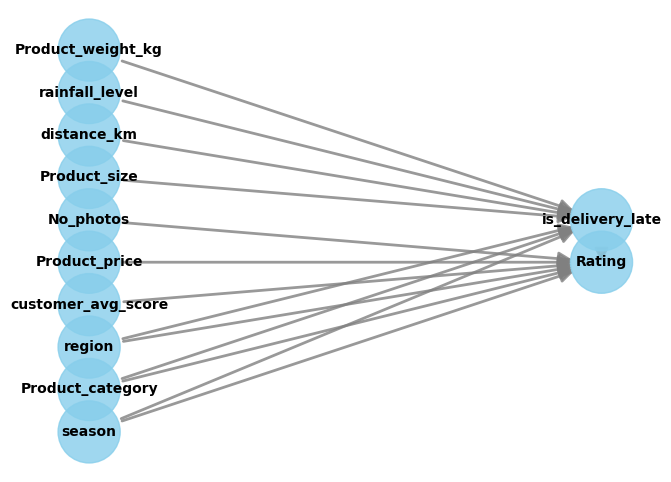

In [154]:
model = CausalModel(data=df_final,
                          graph=causal_graph.replace("\n", " "),
                          treatment="is_delivery_late",
                          outcome="Rating")
model.view_model()

In [155]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                   
───────────────────(E[Rating|Product_category,region,season])
d[is_delivery_late]                                          
Estimand assumption 1, Unconfoundedness: If U→{is_delivery_late} and U→Rating then P(Rating|is_delivery_late,Product_category,region,season,U) = P(Rating|is_delivery_late,Product_category,region,season)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                                             ↪
 ⎢                              d                                       ⎛      ↪
E⎢─────────────────────────────────────────────────────────────(Rating)⋅⎜───── ↪
 ⎣d[distanceₖₘ  Product_size  rainfallₗₑᵥₑₗ  Product_weight_kg]         ⎝d[dis ↪

↪                                                                              ↪
↪                          d           

In [ ]:
# customer_previous_score: better name would be customer_avg_score?
# There should be no capital letters on column names; convention
# let's make sure variable names are easy to understand; not sure what "rainfall" would mean if I had not contenxt